# XGBoost Tutorial 
## Regression: Prediction on House prices
### March 23th 2020

In [139]:
import pandas as pd
import numpy as np 
import seaborn as sns
import os
from matplotlib import pyplot as plt
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [140]:
os.getcwd()

'/home/razielar/Documents/git_rep/Deep-Learning-AI-Barcelona-2018/Tree-based_methods/XGradientBoost'

## 1) Input data

In [141]:
df_train=pd.read_csv('Data/train.csv')
df_test=pd.read_csv('Data/test.csv')

#Obtain all data: 
df_all=df_train.append(df_test)

print(df_test.shape, df_train.shape, df_all.shape)



(1459, 80) (1460, 81) (2919, 81)


## 2) Missing Values

In [142]:
def null_values(df):
    sum_null=df.isnull().sum()
    total=df.isnull().count()
    percent_nullvalues=100*sum_null/total
    df_null= pd.DataFrame()
    df_null['Total']=total
    df_null['Null_Count']=sum_null
    df_null['Percent']=round(percent_nullvalues, 2)
    df_null= df_null.sort_values(by=['Null_Count'], ascending=False)
    df_null= df_null[df_null.Null_Count > 0]
    return df_null

In [143]:
null_values(df=df_all)

,Total,Null_Count,Percent
PoolQC,2919,2909,99.66
MiscFeature,2919,2814,96.40
Alley,2919,2721,93.22
Fence,2919,2348,80.44
SalePrice,2919,1459,49.98
FireplaceQu,2919,1420,48.65
LotFrontage,2919,486,16.65
GarageFinish,2919,159,5.45
GarageQual,2919,159,5.45
GarageCond,2919,159,5.45


In [144]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType'):
    df_all[col] = df_all[col].fillna('None')
    
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType'):
    df_all[col] = df_all[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'):
    df_all[col] = df_all[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_all[col] = df_all[col].fillna('None')    

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_all[col] = df_all[col].fillna(0)

# Total area is the most important in terms of prices.    
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

In [145]:
null_values(df=df_all)

,Total,Null_Count,Percent
SalePrice,2919,1459,49.98
LotFrontage,2919,486,16.65
MSZoning,2919,4,0.14
Utilities,2919,2,0.07
Functional,2919,2,0.07
Exterior2nd,2919,1,0.03
Electrical,2919,1,0.03
SaleType,2919,1,0.03
Exterior1st,2919,1,0.03
KitchenQual,2919,1,0.03


In [146]:
df_all.Electrical.value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [147]:
df_all['Electrical'] = df_all['Electrical'].fillna('SBrkr')
df_all['LotFrontage'] = df_all.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_all['Utilities'] = df_all.drop('Utilities', axis=1)


In [148]:
df_all.YrSold = df_all.YrSold.astype(str)
df_all.MoSold = df_all.MoSold.astype(str)

In [149]:
df_train=df_all[df_all.Id < 1461]
df_test=df_all[df_all.Id >= 1461].drop('SalePrice', axis=1)

In [150]:
null_values(df_train)

,Total,Null_Count,Percent


In [151]:
null_values(df=df_test)

,Total,Null_Count,Percent
MSZoning,1459,4,0.27
Functional,1459,2,0.14
Exterior1st,1459,1,0.07
Exterior2nd,1459,1,0.07
SaleType,1459,1,0.07
KitchenQual,1459,1,0.07


In [152]:
df_test['Exterior1st'] = df_test['Exterior1st'].fillna('VinylSd')
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna('VinylSd')
df_test['KitchenQual'] = df_test['KitchenQual'].fillna('TA')
df_test['Functional'] = df_test['Functional'].fillna('Typ')
df_test['MSZoning'] = df_test['MSZoning'].fillna('RL')
df_test['SaleType'] = df_test['SaleType'].fillna('WD')

## 3) Dummy variables

In [153]:
cols = ( 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'FireplaceQu', 'Electrical',
        'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'ExterQual', 'ExterCond','HeatingQC','KitchenQual', 'Functional', 'MSZoning', 'LandContour',
        'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'LotConfig',
        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'SaleType', 'SaleCondition',
        'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

for i in cols:
    lbl = LabelEncoder() 
    "For train dataset"
    lbl.fit(list(df_train[i].values)) 
    df_train[i] = lbl.transform(list(df_train[i].values))
    
    "For test dataset"
    lbl.fit(list(df_test[i].values)) 
    df_test[i] = lbl.transform(list(df_test[i].values))
    

## 4) Outliers

In [160]:
df_train['SalePriceLog']=np.log(df_train.SalePrice)

corr= df_train.corr().abs()
corr.SalePriceLog[corr.SalePriceLog >=0.5].sort_values(ascending=False)

SalePriceLog    1.000000
SalePrice       0.948374
OverallQual     0.817184
TotalSF         0.777296
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
ExterQual       0.582163
BsmtQual        0.576968
YearRemodAdd    0.565608
TotRmsAbvGrd    0.534422
KitchenQual     0.534386
GarageType      0.503130
Name: SalePriceLog, dtype: float64

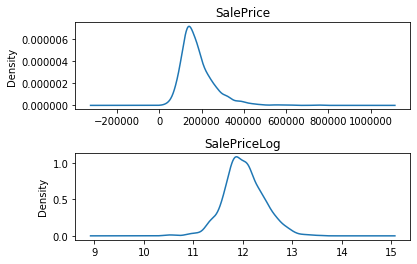

In [180]:
#Using log transformation, right skewed distributions can be a normal distribution

plt.subplot2grid((2,1), (0,0))
df_train.SalePrice.plot(kind="kde")
plt.title('SalePrice')

plt.subplot2grid((2,1), (1,0))
df_train.SalePriceLog.plot(kind='kde')
plt.title('SalePriceLog')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()
